# Catatan Cakrawala Notebook - BDC Satria Data
### Author :
* Dimas Kuncoro Jati
* Muhammad Amanda
* Wahyu Setianto

### Running Environment
* Platform    : Kaggle
* Accelerator : TPU
* Data :
    1. [BDC - Satria Data Catatan Cakrawala](https://www.kaggle.com/wahyusetianto/data-bdc)<br>
    Data original dan data yang telah di preprocess oleh tim Catatan Cakrawala.
    1. [Catatan Cakrawala Model](https://www.kaggle.com/pencarikebahagiaan/modelku) [Optional]<br>
    Model terbaik yang telah di train tim Catatan Cakrawala

### Note :
* Seluruh kode dapat diakses melalui responsitory Github kami [di sini](https://github.com/Hyuto/BDC-Satria-Data)
* Notebook ini juga bisa diakses [di sini](https://www.kaggle.com/wahyusetianto/bdc-main-notebook)

# BDC - Satria Data 2020
## Daftar Isi
1. [Preprocessing Data](#chapter1)
    - [Data Gambar](#chapter1_1)
        1. [Mengecek Missing File](#chapter1_1_1)
        1. [Preprocess & Resizing Image Data](#chapter1_1_2)
        1. [Image Augmentation](#chapter1_1_3)
        1. [Up-Sampling Data](#chapter1_1_4)
    - [Data Teks](#chapter1_2)
        1. [Mengecek Duplicated Value](#chapter1_2_1)
        1. [Mengekstrack Features](#chapter1_2_2)
        1. [Masking Feature (Encode)](#chapter1_2_3)
        1. [Normalisasi Tanda Baca](#chapter1_2_4)
        1. [Decode Masking & Menghapus Tanda Baca](#chapter1_2_5)
        1. [De-Emojized](#chapter1_2_6)
        1. [Mengecek Misspellwords (typo)](#chapter1_2_7)
        1. [Menghapus Stopwords](#chapter1_2_8)
1. [Explorasi Data](#chapter2)
    1. [Mengecek Frekuensi Data Setiap Kelas](#chapter2_1)
    1. [Mengecek Frekuensi Kelas perWaktu](#chapter2_1)
    1. [Mengecek Kata - Kata Setiap Kelas](#chapter2_1)
1. [Pemodelan](#chapter3)
    1. [Pemodelan Data Gambar (EfficientNet)](#chapter3_1)
    1. [Pemodelan Data Teks (BERT)](#chapter3_2)
1. [Ensemble](#chapter4)
    1. [Ensembling](#chapter4_1)
    1. [Mencari Threshold](#chapter4_1)
1. [Kesimpulan & Saran](#chapter5)

## Task
Mendeteksi apakah suatu berita adalah hoax atau bukan hoax (`Binary Classification`).

## Data
* Data Gambar
* Data Text (judul dan narasi berita)

## First Things First
* Install & Load Library
* Global SEED-ing
* Keeping Google Cloud Storage PATH

In [1]:
# Install Package yang Dibutuhkan
!pip install -q --upgrade pip
!pip install -q efficientnet  # EfficientNet
!pip -q install sastrawi      # Santrawi

# Imports
import os, random, re, string, emoji
from timeit import default_timer
from tqdm.notebook import tqdm

# Kaggle Datasets for checking GCS
from kaggle_datasets import KaggleDatasets

# Scientific tools
import numpy as np
import pandas as pd

# Plotting tools
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use("seaborn-notebook")

# Interactive 
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Image processing
from PIL import Image
from skimage.transform import rotate

# Tensorflow and Keras
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array

# Scikit Learn
from sklearn.utils import shuffle
from sklearn.metrics import *
from sklearn.model_selection import *
from sklearn.feature_extraction.text import CountVectorizer

# SEED ALL
SEED = 42

os.environ['PYTHONHASHSEED'] = str(SEED)
random.seed(SEED)
np.random.seed(SEED)

os.environ['TF_DETERMINISTIC_OPS'] = str(SEED)
tf.random.set_seed(SEED)

# GCS PATH
GCS_PATH = KaggleDatasets().get_gcs_path('data-bdc')

# Out
print(f'Using Tensorflow Version       : {tf.__version__}')
print(f'Google Cloud Storage Data Path : {GCS_PATH}')

Using Tensorflow Version       : 2.2.0
Google Cloud Storage Data Path : gs://kds-7a3b4bb00789754aa5925da7c7a9217df698684ced337b42a9790257


# Preprocessing Data<a class="anchor" id="chapter1"></a>
Melakukan preprocessing data sebelum diolah

### Load Dataset
Load dataset ke memory

In [2]:
train = pd.read_excel('../input/data-bdc/Data BDC - Satria Data 2020/Data Latih/Data Latih BDC.xlsx')
test = pd.read_excel('../input/data-bdc/Data BDC - Satria Data 2020/Data Uji/Data Uji BDC.xlsx')
train.head()

ID  label              tanggal  \
0   71      1  2020-08-17 00:00:00   
1  461      1  2020-07-17 00:00:00   
2  495      1  2020-07-13 00:00:00   
3  550      1  2020-07-08 00:00:00   
4  681      1  2020-06-24 00:00:00   

                                               judul  \
0  Pemakaian Masker Menyebabkan Penyakit Legionna...   
1  Instruksi Gubernur Jateng tentang penilangan  ...   
2  Foto Jim Rohn: Jokowi adalah presiden terbaik ...   
3  ini bukan politik, tapi kenyataan Pak Jokowi b...   
4       Foto Kadrun kalo lihat foto ini panas dingin   

                                              narasi nama file gambar  
0  A caller to a radio talk show recently shared ...           71.jpg  
1  Yth.Seluruh Anggota Grup Sesuai Instruksi Gube...          461.png  
2  Jokowi adalah presiden terbaik dlm sejarah ban...          495.png  
3  Maaf Mas2 dan Mbak2, ini bukan politik, tapi k...          550.png  
4        Kadrun kalo lihat foto ini panas dingin . .          681.jpg

## Download Fungsi Tambahan
Mendownload fungsi yang sudah dibuat dari responsitory kami.

In [3]:
!wget -q https://raw.githubusercontent.com/Hyuto/BDC-Satria-Data/master/Preprocess%20code/RPU.py
!wget -q https://raw.githubusercontent.com/Hyuto/BDC-Satria-Data/master/Preprocess%20code/Preprocess.py

## Data Gambar<a class="anchor" id="chapter1_1"></a>
Melakukan preprocessing pada data gambar

### Sesuaikan Path data gambar
Menyesuaikan direktori data gambar

In [4]:
# Train & Test Image PATH
TRAIN_PATH = '../input/data-bdc/Data BDC - Satria Data 2020/Data Latih/File Gambar Data Latih/'
TEST_PATH = '../input/data-bdc/Data BDC - Satria Data 2020/Data Uji/File Gambar Data Uji/'

tambahkan Path ke nama file gambar

In [5]:
# Apply to nama file
TRAIN_IMG = [TRAIN_PATH + x for x in train['nama file gambar'].values]
TEST_IMG = [TEST_PATH + x for x in test['nama file gambar'].values]

## Checking Missing File<a class="anchor" id="chapter1_1_1"></a>
Mengecek apakah ada file yang hilang / tidak bisa terbaca pada direktori gambar.

In [6]:
def check_missing(files, return_missing_ID = True):
    """
    Mengecek keberadaan data gambar berdasarkan direktori
    """
    missing = []
    for file in files:
        if not os.path.isfile(file):
            missing.append(file)
    print(f'[INFO] Missing {len(missing)} file')
    if return_missing_ID:
        return sorted([int(x.split('/')[-1][:-4]) for x in missing])

In [7]:
# Missing pada data TRAIN
missing_train = check_missing(TRAIN_IMG)
missing_train

[INFO] Missing 9 file


[48121, 275477, 343052, 367583, 555990, 697754, 697955, 742855, 743885]

In [8]:
# Missing pada data TEST
missing_test = check_missing(TEST_IMG)
missing_test

[INFO] Missing 2 file


[690192, 693499]

Terdapat 9 file gambar pada data train dan 2 file gambar pada data test yang hilang. Hal ini diduga karena nama file berbeda pada direktori gambar dengan nama file yang ada pada dataframe. Maka dari itu kami melakukan pengecekan nama file pada direktori gambar dengan menyamakan `ID`-nya.

In [9]:
def fixing_extensions(missing, path):
    """
    Membenarkan ekstensi file gambar yang di anggap hilang
    dari direktori.
    """
    res = []
    for miss in missing:
        fixed = False
        list_dir = os.listdir(path)
        for i in range(len(list_dir)):
            if miss == int(list_dir[i][:-4]):
                fixed = True
                res.append((miss, list_dir[i]))
                break
        if not fixed:
            res.append((miss, '404')) # Not Found
    return res

In [10]:
# Apply function
fixed_missing_train = fixing_extensions(missing_train, TRAIN_PATH)
fixed_missing_test = fixing_extensions(missing_test, TEST_PATH)

Setelah nama file yang hilang dibenarkan, apply nama file yang benar ke main dataframe.

In [11]:
# Apply to train DF
for Id, filename in fixed_missing_train:
    index = train.ID.tolist().index(Id)
    train.loc[index, 'nama file gambar'] = filename

# Apply to test DF
for Id, filename in fixed_missing_test:
    index = test.ID.tolist().index(Id)
    test.loc[index, 'nama file gambar'] = filename

Spesifikasi ulang nama file gambar

In [12]:
TRAIN_X = [TRAIN_PATH + x for x in train['nama file gambar'].values if x != '404']
TRAIN_y = train.label.values

### Menampilkan Data Gambar
Menampilkan beberapa data gambar yang ada

In [13]:
def read_and_resize(path):
    """
    Read & Resize data gambar
    """
    img = Image.open(path)
    img.resize((256, 256), Image.ANTIALIAS)
    return img

def show_images(list_dir, label, load_image = read_and_resize, seed = SEED):
    """
    Menampilkan Gambar Secara acak berdasarkan kelasnya 
    masing - masing sebanyak 5 buah.
    """
    random.seed(seed)
    data_0 = random.sample([x for x in zip(list_dir, label) if x[1] == 0], 5)
    data_1 = random.sample([x for x in zip(list_dir, label) if x[1] == 1], 5)
    fig, axes = plt.subplots(2, 5, figsize = (20, 10))
    for i in range(2):
        if i == 0:
            data = data_0
        else:
            data = data_1
        for j in range(5):
            img = load_image(data[j][0])
            axes[i, j].imshow(img)
            axes[i, j].set_title(f'Label : {data[j][1]}', fontsize = 14)
            axes[i, j].axis('off')
    fig.tight_layout()
    plt.show()

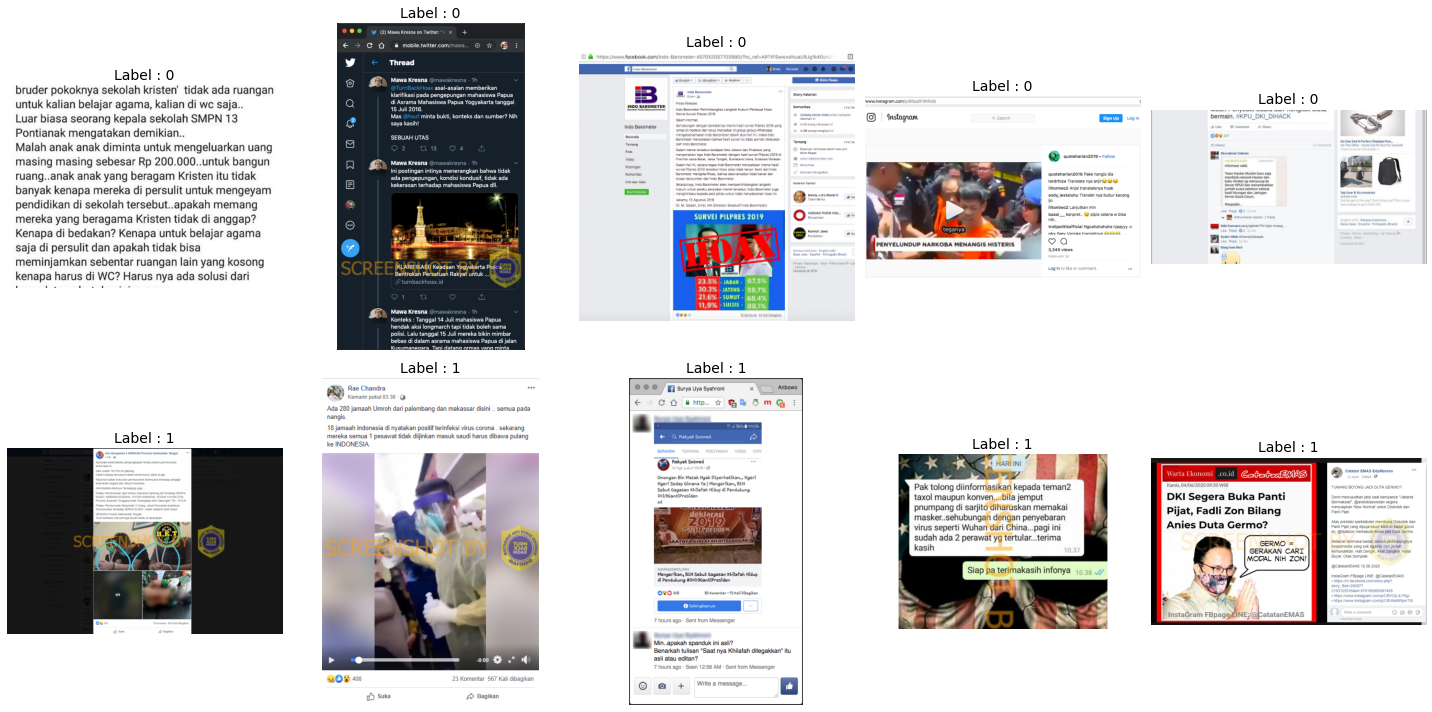

In [14]:
show_images(TRAIN_X, TRAIN_y)

Dapat dilihat gambar memiliki resolusi yang `berbeda - beda`.

### Preprocess and Resizing<a class="anchor" id="chapter1_1_2"></a>
Untuk mengatasi data gambar dengan resolusi yang berbeda - beda maka dilakukan dengan metode croping pada bagian `center` gambar dan `resizing` gambar tersebut ke ukuran yang di tetapkan.

In [15]:
def load_and_preprocess_image(path: str, size = [256, 256]):
    """
    Load & Preprocess data gambar
    """
    image = img_to_array(load_img(path))
    img = tf.convert_to_tensor(image, dtype=tf.float32)
    shapes = tf.shape(img)
    h, w = shapes[-3], shapes[-2]
    dim = tf.minimum(h, w)
    img = tf.image.resize_with_crop_or_pad(img, dim, dim)
    img = tf.image.resize(img, size)
    img = tf.cast(img, tf.float32) / 255.0
    return img.numpy()

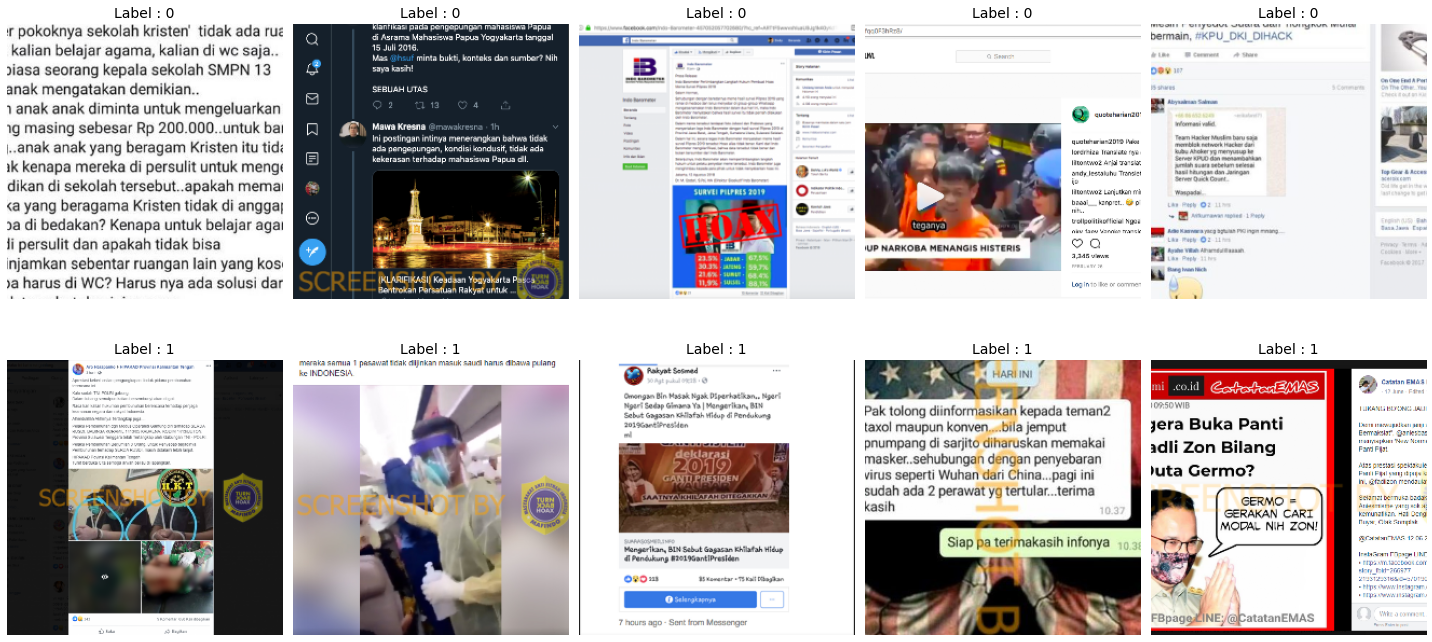

In [16]:
show_images(TRAIN_X, TRAIN_y, load_and_preprocess_image)

### Image Augmentation<a class="anchor" id="chapter1_1_3"></a>
Karena data yang ada tidak seimbang maka perlu dilakukan penambahan data. Metode yang digunakan untuk menambahkan data yaitu augmentasi data gambar pada kelas yang sedikit dengan melakukan `random rotation`.

Metode Augmentasi yang digunakan.
```
Rotasi Acak dengan nilai rotasi di random pada kisaran -70 sd 70 derajad
```

In [17]:
data_augmentation = lambda x : (
    rotate(x, random.randint(-70, 70), mode='reflect')
)

Menampilkan hasil dari augmentasi.

In [18]:
def AUG_test(X):
    """
    Plot gambar dengan fungsi Augmentasi
    """
    X = load_and_preprocess_image(X)
    fig, axes = plt.subplots(1, 5, figsize = (20,10))
    axes[0].imshow(X)
    axes[0].set_title('Actual', fontsize = 14)
    axes[0].axis('off')
    for i in range(1, 5):
        aug = data_augmentation(X)
        axes[i].imshow(aug)
        axes[i].set_title('Augmented', fontsize = 14)
        axes[i].axis('off')
    fig.tight_layout()
    return plt.show()

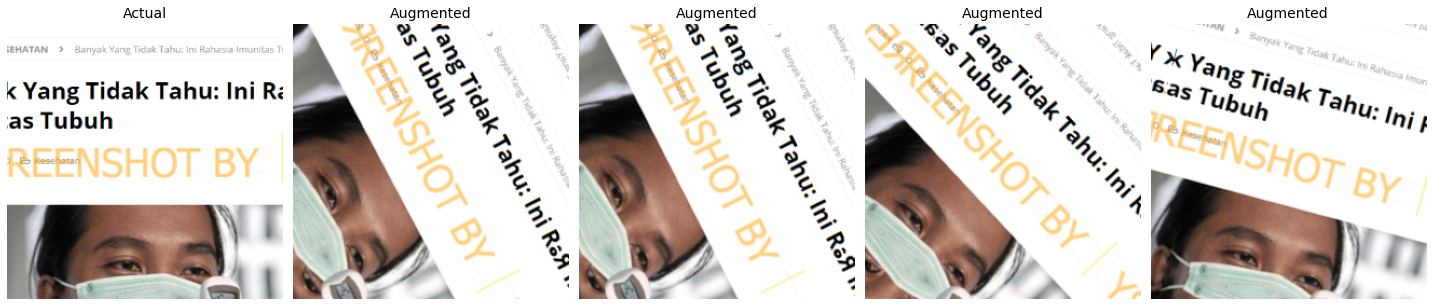

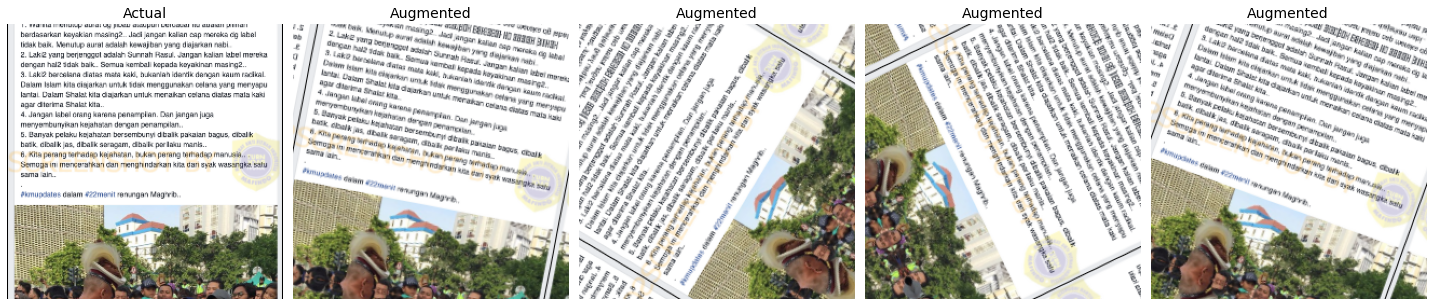

In [19]:
for i in random.sample(TRAIN_X, 2):
    AUG_test(i)

### Up Sampling Data<a class="anchor" id="chapter1_1_4"></a>
Mengapply Preprocess & Augmentasi ke data gambar dan menyimpan gambar pada direktori baru.
Menggunakan Fungsi tambahan yang sudah di download pada file `RPU.py`

Fungsi akan mengembalikan List direktori gambar dan juga labelnya.

`ApplyAUG -> IMAGE_DIR, Label`

Contoh Penggunaan
```
from RPU import ApplyAUG

TRAIN_X, TRAIN_y = (
       ApplyAUG(TRAIN_X,               # List atau Array direktori dari gambar
                TRAIN_y,               # List atau Array kelas(label) dari TRAIN_X [One Hot Encoding]
                PATH,                  # Direktori data gambar
                up_sample_ratio = 1,   # Rasio Up Sample
                up_sample_class = '0', # Spesifikasi Class yang akan di Up Sample  
                data_aug = data_augmentation,  # Fungsi Augmentasi
                LP = load_and_preprocess_image # Fungsi Load & Preprocess
                )
)
```
Atau bisa juga menggunakan shell
```
!python RPU.py PATH SIZE TEST_SIZE UP_SAMPLES UP_SAMPLE_CLASS
```
Namun pada kernel ini tidak akan di gunakan fungsi tersebut. Melaikan menggunakan hasil dari fungsi tersebut, karena kernel ini di run pada TPU & TPU tidak dapat membaca file diluar dari `GCS` (lokal direktori).

Note : Up Sample data pada Notebook ini didapatkan dengan command berikut
```
!python RPU.py '../input/data-bdc/Data BDC - Satria Data 2020/Data Latih/File Gambar Data Latih/' \
                SIZE:512 TEST_SIZE:0.15 UP_SAMPLES:0.5-1-2 UP_SAMPLE_CLASS:0
```

## Data Text<a class="anchor" id="chapter1_2"></a>
Melakukan preprocessing pada data text. 

Load fungsi pada file `Preprocess.py` terlebih dahulu

In [20]:
from Preprocess import *

Pada notebook ini pengolahan data text dilakukan menggunakan `judul` dan `narasi`, sehingga perlu dilakukan penyatuan kolom `judul` dan kolom `narasi` dipisahkan dengan spasi.

In [21]:
train['text'] = (train['judul'] + ' ' + train['narasi']).apply(lambda x : x.lower())
test['text'] = (test['judul'] + ' ' + test['narasi']).apply(lambda x : x.lower())
train.head()

ID  label              tanggal  \
0   71      1  2020-08-17 00:00:00   
1  461      1  2020-07-17 00:00:00   
2  495      1  2020-07-13 00:00:00   
3  550      1  2020-07-08 00:00:00   
4  681      1  2020-06-24 00:00:00   

                                               judul  \
0  Pemakaian Masker Menyebabkan Penyakit Legionna...   
1  Instruksi Gubernur Jateng tentang penilangan  ...   
2  Foto Jim Rohn: Jokowi adalah presiden terbaik ...   
3  ini bukan politik, tapi kenyataan Pak Jokowi b...   
4       Foto Kadrun kalo lihat foto ini panas dingin   

                                              narasi nama file gambar  \
0  A caller to a radio talk show recently shared ...           71.jpg   
1  Yth.Seluruh Anggota Grup Sesuai Instruksi Gube...          461.png   
2  Jokowi adalah presiden terbaik dlm sejarah ban...          495.png   
3  Maaf Mas2 dan Mbak2, ini bukan politik, tapi k...          550.png   
4        Kadrun kalo lihat foto ini panas dingin . .          681.jpg   

                                                text  
0  pemakaian masker menyebabkan penyakit legionna...  
1  instruksi gubernur jateng tentang penilangan  ...  
2  foto jim rohn: jokowi adalah presiden terbaik ...  
3  ini bukan politik, tapi kenyataan pak jokowi b...  
4  foto kadrun kalo lihat foto ini panas dingin k...

### Mengecek Duplicated Values<a class="anchor" id="chapter1_2_1"></a>
Mengecek keberadaan data yang berduplikasi.

In [22]:
train[train.duplicated(subset=['text'], keep=False)]

ID  label              tanggal  \
559   130974      0  2015-11-28 00:00:00   
604   140123      1  2020-06-02 00:00:00   
812   188319      0  2015-11-28 00:00:00   
1344  312152      1  2020-06-02 00:00:00   
3824  898927      1  2018-03-12 00:00:00   
3927  923503      1  2018-03-12 00:00:00   

                                                  judul  \
559   Jokowi Lebih Memilih Helikopter Buatan Luar Ne...   
604   Foto Sekarang malesiya sapu habis penduduk asi...   
812   Jokowi Lebih Memilih Helikopter Buatan Luar Ne...   
1344  Foto Sekarang malesiya sapu habis penduduk asi...   
3824  Soal Bocornya NIK dan Nomor KK Sekarang dilemp...   
3927  Soal Bocornya NIK dan Nomor KK Sekarang dilemp...   

                                                 narasi nama file gambar  \
559   INSTING MAKELAR\n \n AKU Awalnya kaget, membac...       130974.png   
604   Perhatian perhatian Sekarang malesiya makin da...       140123.jpg   
812   INSTING MAKELAR\n \n AKU Awalnya kaget, membac...       188319.png   
1344  Perhatian perhatian Sekarang malesiya makin da...       312152.jpg   
3824  Siapa yang disalahkan ?\n Saling lempar tanggu...       898927.jpg   
3927  Siapa yang disalahkan ?\n Saling lempar tanggu...       923503.png   

                                                   text  
559   jokowi lebih memilih helikopter buatan luar ne...  
604   foto sekarang malesiya sapu habis penduduk asi...  
812   jokowi lebih memilih helikopter buatan luar ne...  
1344  foto sekarang malesiya sapu habis penduduk asi...  
3824  soal bocornya nik dan nomor kk sekarang dilemp...  
3927  soal bocornya nik dan nomor kk sekarang dilemp...

Menghapus data yang berduplikasi

In [23]:
# Drop duplicates row
train = train.drop_duplicates(subset ="text").reset_index()

In [24]:
def clean_up(arr):
    r"""
    Cleanup \n and lowering text
    """
    for i in range(len(arr)):
        arr[i] = arr[i].lower()
        arr[i] = re.sub('\n', ' ', arr[i])
        arr[i] = ' '.join(arr[i].split())
    return arr

In [25]:
# Init text
train_text = clean_up(train.text.values)
test_text = clean_up(test.text.values)

### Mengekstrack Feature dari Text<a class="anchor" id="chapter1_2_2"></a>
Mengekstrack feature seperti `URL`, `Hashtag`, `Tag`, dan `Emoji` dari text untuk melihat informasi dan frekuensi kemunculannya dalam setiap kelas pada data

In [26]:
%%time
FE = FeatureExtraction()
FE_test = FeatureExtraction()
FE.fit(train_text, train.label.values)
FE_test.fit(test_text)

CPU times: user 6.09 s, sys: 18 ms, total: 6.11 s
Wall time: 6.11 s


In [27]:
FE.get_table('urls', return_prop = True)

urls         0         1  \
0                                          kompas.com  0.333333  0.666667   
1                                          viva.co.id  0.000000  1.000000   
2                                          seword.com  0.500000  0.500000   
3                                       opishposh.com  0.500000  0.500000   
4                             https://t.co/jvjxc0jhmp  0.000000  1.000000   
..                                                ...       ...       ...   
80  http://poskotanews.com/…/pa-212-batalkan-acara...  0.000000  1.000000   
81                              www.piyunganonline.co  0.000000  1.000000   
82                              https://goo.gl/2xz5yn  0.000000  1.000000   
83                          corona-virus-map.com.exe.  1.000000  0.000000   
84  https://sekolahnews.com/daftar-passing-grade-u...  0.000000  1.000000   

    frekuensi  max_prop  
0           3  0.666667  
1           2  1.000000  
2           2  0.500000  
3           2  0.500000  
4           1  1.000000  
..        ...       ...  
80          1  1.000000  
81          1  1.000000  
82          1  1.000000  
83          1  1.000000  
84          1  1.000000  

[85 rows x 5 columns]

In [28]:
FE.get_table('hashtags', return_prop = True)

hashtags         0         1  frekuensi  max_prop
0    #2019gantipresiden  0.133333  0.866667         15  0.866667
1              #covid19  0.000000  1.000000          5  1.000000
2                 #2019  0.000000  1.000000          4  1.000000
3          #coronavirus  0.000000  1.000000          3  1.000000
4             #stayhome  0.000000  1.000000          3  1.000000
..                  ...       ...       ...        ...       ...
351        #sekolahnews  0.000000  1.000000          1  1.000000
352           #wkwkland  0.000000  1.000000          1  1.000000
353          #abusendal  0.000000  1.000000          1  1.000000
354      #sayapancasila  1.000000  0.000000          1  1.000000
355      #sayaindonesia  1.000000  0.000000          1  1.000000

[356 rows x 5 columns]

In [29]:
FE.get_table('tags', return_prop = True)

tags         0         1  frekuensi  max_prop
0           @jokowi  0.111111  0.888889          9  0.888889
1    @aniesbaswedan  0.000000  1.000000          6  1.000000
2          @prabowo  0.166667  0.833333          6  0.833333
3         @fadlizon  0.200000  0.800000          5  0.800000
4      @netizentofa  0.000000  1.000000          2  1.000000
..              ...       ...       ...        ...       ...
142    @kemenhub151  0.000000  1.000000          1  1.000000
143       @ricky_hf  0.000000  1.000000          1  1.000000
144         @kai121  0.000000  1.000000          1  1.000000
145    @ankertwiter  0.000000  1.000000          1  1.000000
146   @commuterline  0.000000  1.000000          1  1.000000

[147 rows x 5 columns]

In [30]:
FE.get_table('emojis', return_prop = True)

emojis         0         1  frekuensi  max_prop
0       😂  0.076923  0.923077         13  0.923077
1       😭  0.142857  0.857143          7  0.857143
2       🙏  0.285714  0.714286          7  0.714286
3       😢  0.166667  0.833333          6  0.833333
4       😍  0.000000  1.000000          5  1.000000
..    ...       ...       ...        ...       ...
66     🇲🇨  0.000000  1.000000          1  1.000000
67      ⏬  0.000000  1.000000          1  1.000000
68      😛  0.000000  1.000000          1  1.000000
69      😟  0.000000  1.000000          1  1.000000
70     2⃣  0.000000  1.000000          1  1.000000

[71 rows x 5 columns]

Karena jumlah data yang cukup kecil dan sepertinya setiap feature memiliki informasi yang cukup berpengaruh terhadap kelasnya, kami memutuskan untuk tidak menghapus satupun feature yang ada.

### Masking Feature (Encode)<a class="anchor" id="chapter1_2_3"></a>
Masking feature pada text. Feauture yang sudah di `.fit` pada data sebelumnya, proses ini dilakukan karena pada feature ini terdapat peletakan tanda baca yang random / tidak beraturan, sedangkan pada proses berikutnya akan dilakukan penormalisasian tanda baca sehingga akan mengganggu proses tersebut. Maka dari itu perlu dilakukan masking agar proses normalisasi kalimat berjalan dengan lancar.
```
# Contoh
Website Google adalah http://google.com/
Trending #MosiTidakPercaya
@jokowi adalah presiden RI
Lucu 😂

# Encode
Website Google adalah MASKURLS1MASK
Trending MASKHASHTAGS1MASK
MASKTAGS1MASK adalah presiden RI
Lucu MASKEMOJIS1MASK
```

In [31]:
# Build Mask Code
FE.build_mask_code(0)
FE_test.build_mask_code(0)
# Apply to data
train_text = FE.encode(train_text)    # Train
test_text = FE_test.encode(test_text) # Test

### Normalisasi Tanda Baca<a class="anchor" id="chapter1_2_4"></a>
Melakukan normalisasi tanda baca pada text. Karena banyak peletakan tanda baca yang salah pada text yang akan mengganggu `tokenizer` dalam melakukan segmentasi pada kalimat.
```
# Contoh
Budi membayar2.000 ban yang dibelinya senilai rp.2.000.000

# Preprocessed
Budi membayar 2.000 ban yang dibelinya senilai rp. 2.000.000
```

In [32]:
# Add more string punctuation
string.punctuation += '‘’…“”–'

In [33]:
def normalize(array):
    """
    Normalize text
    """
    punc, arr = string.punctuation, array.copy()
    for i in range(len(arr)):
        temp = list(arr[i])
        for j in range(1, len(temp) - 1):
            if (temp[j] in punc) and not\
            all([x in string.digits for x in [temp[j-1], temp[j+1]]]):
                temp[j] = ' ' + temp[j] + ' '
            elif (temp[j] in string.ascii_lowercase) and (temp[j + 1] \
            in string.digits or temp[j + 1] in string.punctuation):
                temp[j] += ' '
        arr[i] = ''.join(temp)
        arr[i] = ' '.join(arr[i].split())
    return arr

In [34]:
# Apply to text
train_text = normalize(train_text) # Train
test_text = normalize(test_text)   # Test

### Decode & Menghapus Tanda Baca<a class="anchor" id="chapter1_2_5"></a>
Men-Decode (mengembalikan feature) serta menghapus tanda baca yang ada pada text.
```
# Contoh
Website Google adalah MASKURLS1MASK

# Decode
Website Google adalah http://google.com/

# Remove Punctuation
Website Google adalah httpgooglecom
```

In [35]:
def remove_punc(arr, punc_):
    """
    Remove string punctuation
    """
    return asarray([x.translate(str.maketrans('', '', punc_))
                    for x in arr])

In [36]:
# Apply to data
train_text = FE.decode(train_text)    # Train
train_text = remove_punc(train_text, string.punctuation)
test_text = FE_test.decode(test_text) # Test
test_text = remove_punc(test_text, string.punctuation)

### De-Emojized<a class="anchor" id="chapter1_2_6"></a>
Mengubah kode emoji yang ada pada text menjadi kata kata yang dapat dimengerti.
```
🙏 -> folded hands
😃 -> grinning face with big eyes
```

In [37]:
def deemojized(arr):
    """
    De Emojized text
    """
    for i in range(len(arr)):
        arr[i] = emoji.demojize(arr[i])
        arr[i] = re.sub(':', ' ', arr[i])
        arr[i] = re.sub('_', ' ', arr[i])
        arr[i] = ' '.join(arr[i].split())
    return arr

In [38]:
# Apply to data
train_text = deemojized(train_text) # Train
test_text = deemojized(test_text)   # Test

### Mengecek Kata yang Misspell (typo)<a class="anchor" id="chapter1_2_7"></a>
Mengecek kata-kata yang misspell atau typo serta kata - kata singkatan. 

1. Membangun Vocabulary<br>
Membangun Vocabulary dari data untuk di cek secara **Manual**

In [39]:
# Count Vectorizer
count = CountVectorizer()
count.fit(train_text)

CountVectorizer()

In [40]:
# Vocabulary to DataFrame
vocab = pd.DataFrame({'Vocab' : list(count.vocabulary_.keys()), 
                     'Word Index' : list(count.vocabulary_.values())})
vocab = vocab.sort_values(by=['Word Index'], ascending = False)
vocab[:30].style.hide_index()

Dapat dilihat dari tabel diatas bahwa data terdiri dari beberapa bahasa karena terdapat beberapa kata yang bukan berasal dari bahasa Indonesia seperti `ﾟﾏﾻ`, `加油jiayou`, `হয়`, `সল`, dll.

2. Mengeksport Vocabulary <br>
Mengeksport vocabulary telah dibangun kedalam file `.txt` untuk dapat dilakukan pengecekan secara manual terhadap kata-kata tersebut.
```
f = open("vocab.txt", "w")
f.write(" \n".join(sorted(vocab.Vocab.values)))
f.close()
```

Selanjutnya, mengimport file yang berisi kata - kata yang telah di cek secara manual lalu mengapikasikannya pada data text menggunakan kelas `SpellChecker`, fitting didapat dilakukan pada file yang diinginkan atau dapat menggunakan file yang telah di benarkan oleh tim Catatan Cakrawala dengan mengisikan `cc-hand-fixed` pada saat fitting class.

In [41]:
spellchecker = SpellChecker()
spellchecker.fit('cc-hand-fixed')

`Transform` untuk apply pada data.

In [42]:
# Apply to Data
train_text = spellchecker.transform(train_text) # Train
test_text = spellchecker.transform(test_text)   # Test

### Memhapus Kata yang Kurang Penting & Stopwords<a class="anchor" id="chapter1_2_8"></a>
Menghapus kata - kata yang kurang penting seperti kata yang hanya terdiri dari 1 karakter dan Stopwords. Untuk Stopwords kami menggabungkan stopwords bahasa Indonesia dari `Spacy` dan `Sastrawi` serta bahasa Inggris dari `Spacy`.

In [43]:
from spacy.lang.id.stop_words import STOP_WORDS as ID
from spacy.lang.en.stop_words import STOP_WORDS as EN
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory

stopwords = set(StopWordRemoverFactory().get_stop_words())
stopwords.update(EN)
stopwords.update(ID)

In [44]:
def RUnecesarry(array, stopwords):
    """
    Remove Unnecessary words
    """
    arr = array.copy()
    for i in range(len(arr)):
        temp = arr[i].split()
        temp = [x for x in temp if not (len(x) == 1 and \
                (x in string.ascii_lowercase or x in string.digits))]
        temp = [x for x in temp if x not in stopwords]
        arr[i] = ' '.join(temp).lower()
    return arr

In [45]:
# Apply to data
train_text = RUnecesarry(train_text, stopwords) # Train
test_text = RUnecesarry(test_text, stopwords)   # Test

Melihat hasil dari tahap preprocess data text

In [46]:
for i in [0, 803, 1002]:
    print(f"Actual : \n{train.text.values[i]}\n\nPreprocessed : \n{train_text[i]}")
    print(''.rjust(80, '-'))

Actual : 
pemakaian masker menyebabkan penyakit legionnaires a caller to a radio talk show recently shared that his wife was hospitalized n told she had covid n only a couple of days left to live . a doctor friend suggested she be tested for legionnaires disease because she wore the same mask every day all day long . turns out it was legionnaires disease from the moisture n bacteria in her mask . she was given antibiotics n within two days was better . what if these ‘spikes’ in covid are really something else due to ‘mask induced infections’ .??🤔🤔🤔

Preprocessed : 
pemakaian masker menyebabkan penyakit legionnaires caller radio talk recently shared wife hospitalized told covid couple days left live doctor friend suggested tested legionnaires disease wore mask day day long turns legionnaires disease moisture bacteria mask given antibiotics days better spikes covid mask induced infections thinking face thinking face thinking face
----------------------------------------------------------

# Explorasi Data<a class="anchor" id="chapter2"></a>
Melakukan explorasi pada data untuk mendapatkan informasi - informasi lebih jauh dari data.

In [47]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4228 entries, 0 to 4227
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   index             4228 non-null   int64 
 1   ID                4228 non-null   int64 
 2   label             4228 non-null   int64 
 3   tanggal           4228 non-null   object
 4   judul             4228 non-null   object
 5   narasi            4228 non-null   object
 6   nama file gambar  4228 non-null   object
 7   text              4228 non-null   object
dtypes: int64(3), object(5)
memory usage: 264.4+ KB


Merubah tipe pada kolom tanggal menjadi `datetime`. Kolom tanggal tidak dapat langsung dirubah tipe datanya menjadi `datetime` dikarenakan ada nya beberapa element yang mengandung kata `Okt` dan `Agu` sehingga harus diubah menjadi `Oct` dan `Aug`

In [48]:
def FixMonth(text):
    """
    Fungsi untuk merubah kata 'Okt' menjadi 'Oct' dan 'Agu' menjadi 'Aug'
    """
    if type(text) == str:
        if 'Okt' in text: return text[:3]+'Oct'+text[6:]
        else: return text[:3]+'Aug'+text[6:]
    else:
        return text

In [49]:
# Apply to data
train['tanggal'] = train['tanggal'].apply(FixMonth)
train['tanggal'] = pd.to_datetime(train['tanggal'])

## Mengecek Frekuensi Setiap Kelas<a class="anchor" id="chapter2_1"></a>
Menegecek frekuensi tiap kelasnya pada data.

In [50]:
fig_1 = go.Figure(go.Pie(labels=['Bukan Hoax', 'Hoax'],
                       values=train.groupby('label').size().values, 
                       textinfo='percent+label+value', 
                       textfont_color='#ffffff', 
                       marker_colors=['#0db7c5','#d03850'])
               )
fig_1.update_layout(
    title={
        'text': "Frekuensi Perkelasnya",
        'y':0.93,
        'x':0.5,
        'font_size':23},
    width=550, height=550
)

fig_1.show()

Dapat dilihat bahwa kelas 1 (`Hoax`) jauh lebih banyak dari kelas 0 (`Bukan Hoax`) atau terdapat `imbalance class` pada data. Untuk penanganannya kami menggunakan `Stratify` saat melakukan `Cross Validation` sehingga proporsi pada subset `latih` dan pada subset `validasi` sama.

## Melihat Sebaran Kelas per Waktunya<a class="anchor" id="chapter2_2"></a>
Melihat sebaran kelas perwaktunya.
1. Membuat kolom baru untuk menyimpan tahun & bulan
1. Mengelompokkan berdasarkan tahun, bulan, dan labelnya

In [51]:
# Membuat Kolom baru untuk menyimpan nilai tahun dan bulan
train['year'] = [i.year for i in train.tanggal]
train['month'] = [i.month for i in train.tanggal]
# Grouping 
data_waktu = (train.groupby(['year', 'month', 'label']).size().reset_index()
              .pivot_table(columns='label', index=['year','month'], values=0))

In [52]:
fig_2 = go.Figure(data=[ 
    go.Bar(name='Bukan Hoax', 
           x=[str(i) for i in data_waktu.index], 
           y=data_waktu[0].values, 
           marker_color='#0db7c5'),
    go.Bar(name='Hoax',
           x=[str(i) for i in data_waktu.index], 
           y=data_waktu[1].values, 
           marker_color='#d03850')
])

fig_2.update_layout(barmode='stack', 
                  xaxis=dict(dtick=1,
                             showgrid=False, 
                             title='(Tahun, Bulan)'),
                  legend=dict(x=0.006,y=0.97, 
                              bgcolor='rgba(255,255,255,0)', 
                              bordercolor='rgba(0,0,0,0)',
                              font_color='#090919',
                              font_size=14),
                  title=dict(text='Sebaran Hoax per Waktu',
                             x=0.5,
                             y=0.9,
                             font_size=23),
                  width=1000,height=550
                 )

fig_2.show()

Ditinjau dari grafik diatas bahwa:
1. 53% dari keseluruhan data berasal dari tahun 2019 - 2020
1. 95% data pada tahun 2019 - 2020 adalah Hoax

### Mengecek Kata - Kata yang Muncul Perkelasnya<a class="anchor" id="chapter2_3"></a>
Mengecek frekuensi kata - kata yang muncul berdasarkan kelasnya.

In [53]:
def find_words(texts, label, builder = CountVectorizer(min_df=3, max_df=0.9,
                                                       ngram_range=(1,2))):
    """
    Memeriksa kalimat berdasarkan kelasnya untuk membuat vocab
    """
    builder.fit(texts)
    n_class, res = len(set(label)), {}
    for i in tqdm(range(len(texts))):
        for vocab in texts[i].split():
            if vocab in builder.vocabulary_:
                if vocab not in res:
                    res[vocab] = [0] * n_class + [0]
                res[vocab][label[i]] += 1
                res[vocab][-1] += 1
    df = pd.DataFrame({'kata' : list(res.keys())})
    for i in range(n_class):
        df[f'Kelas_{i}'] = [res[x][i] for x in res]
    df['Frekuensi'] = [res[x][-1] for x in res]
    return df.sort_values(by = ['Frekuensi'], ascending = False).reset_index(drop=True)

In [54]:
# Vocab DF per class
words = find_words(train_text, train.label.values)
words['Max_prop'] = words[['Kelas_0', 'Kelas_1']].max(axis = 1) / words['Frekuensi']
words.head(10)

kata  Kelas_0  Kelas_1  Frekuensi  Max_prop
0  indonesia      160      617        777  0.794080
1     jokowi       93      522        615  0.848780
2       foto       79      446        525  0.849524
3      orang       66      458        524  0.874046
4      video       62      378        440  0.859091
5     corona       15      402        417  0.964029
6       anak       62      342        404  0.846535
7      virus       21      378        399  0.947368
8      covid       24      342        366  0.934426
9      china       33      324        357  0.907563

Berikut adalah Barplot untuk kata - kata pada kelas `1` yang mempunyai frekuensi kumunculan lebih dari kelas `0`.

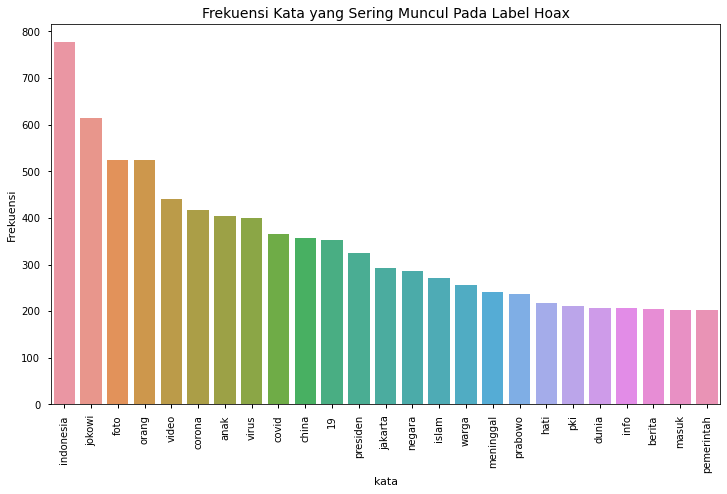

In [55]:
_1 = words[(words['Kelas_1'] > words['Kelas_0'])]

plt.figure(figsize = (12,7))
sns.barplot(x = 'kata', y = 'Frekuensi', data = _1[:25])
plt.title('Frekuensi Kata yang Sering Muncul Pada Label Hoax', fontsize = 14)
plt.xticks(rotation = 90)
plt.show()

Plotting WordCloud

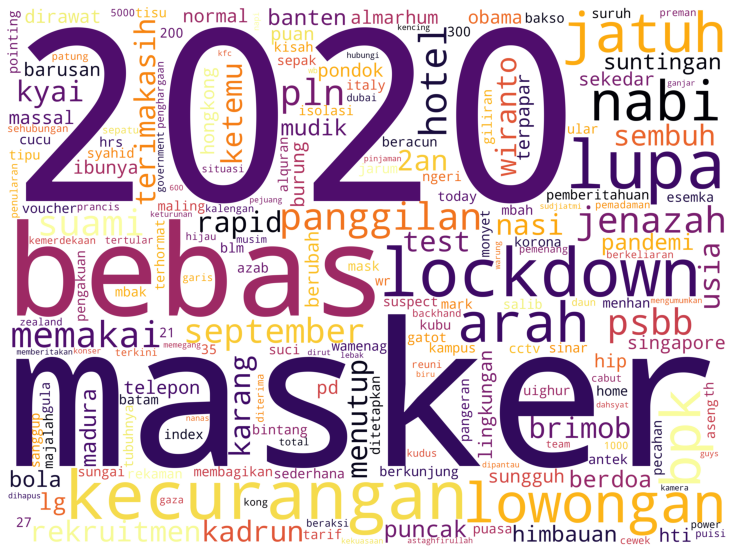

In [56]:
from wordcloud import WordCloud, ImageColorGenerator

__1 = {}
for i in range(len(_1)):
    __1[_1.kata.values[i]] = _1.Max_prop.values[i]
    
wordcloud = WordCloud(width = 4000, height = 3000, min_font_size = 5, 
                      background_color = 'white', colormap = 'inferno').fit_words(__1)
plt.figure(figsize = (10, 8)) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0)
plt.show() 

Berikut adalah Barplot untuk kata - kata pada kelas `0` yang mempunyai frekuensi kumunculan lebih dari kelas `1`.

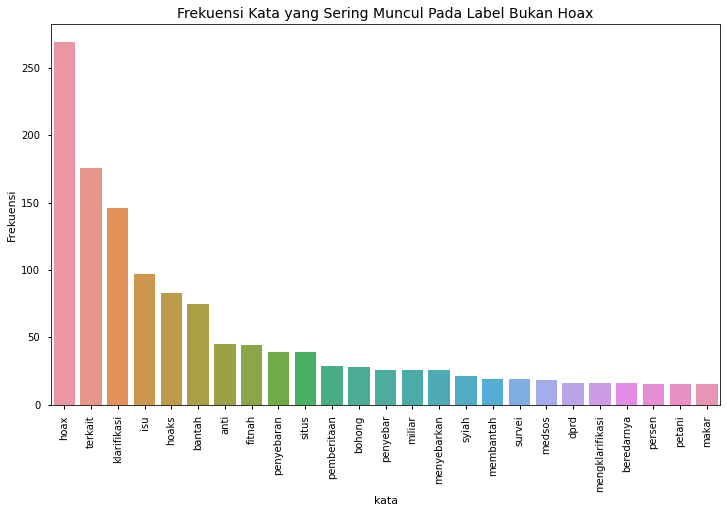

In [57]:
_0 = words[(words['Kelas_0'] > words['Kelas_1'])]

plt.figure(figsize = (12,7))
sns.barplot(x = 'kata', y = 'Frekuensi', data = _0[:25])
plt.title('Frekuensi Kata yang Sering Muncul Pada Label Bukan Hoax', fontsize = 14)
plt.xticks(rotation = 90)
plt.show()

Plotting WordCloud

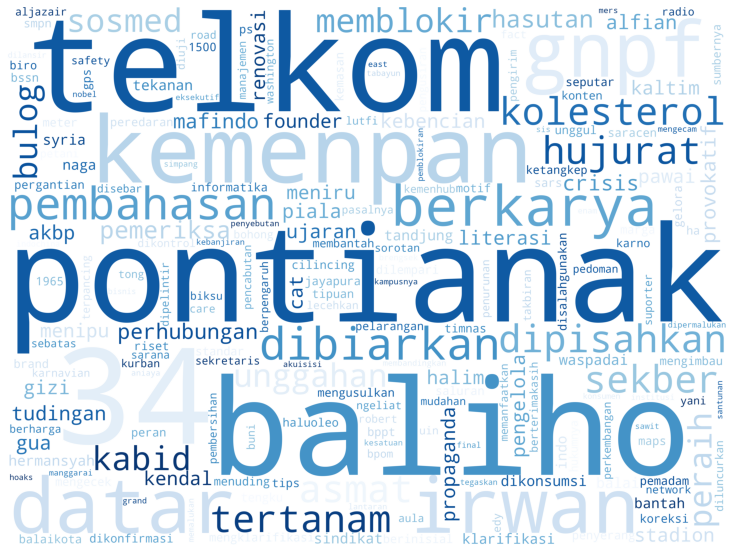

In [58]:
__0 = {}
for i in range(len(_0)):
    __0[_0.kata.values[i]] = _0.Max_prop.values[i]
    
wordcloud = WordCloud(width = 4000, height = 3000, min_font_size = 5, 
                      background_color = 'white', colormap = 'Blues').fit_words(__0)

plt.figure(figsize = (10, 8)) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
plt.show() 

# Pemodelan<a class="anchor" id="chapter3"></a>
Membuat model untuk memprediksi kelas `0` (`tidak hoax`) dan kelas `1` (`hoax`) pada data test.

## Accelerator Detection
Menggunakan GPU atau TPU dari Kaggle sebagai Accelerator.

Note : Pastikan untuk menyalakan GPU / TPU sebagai Accelator, untuk effisiensi waktu pelatihan model.

In [59]:
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Running on TPU ', tpu.master())
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
    BATCH_SIZE = 16 * strategy.num_replicas_in_sync
else:
    strategy = tf.distribute.get_strategy()
    BATCH_SIZE = 32 * strategy.num_replicas_in_sync
    
AUTO = tf.data.experimental.AUTOTUNE
print("REPLICAS: ", strategy.num_replicas_in_sync)

Running on TPU  grpc://10.0.0.2:8470
REPLICAS:  8


## Pemodelan Data Gambar (EfficientNet)<a class="anchor" id="chapter3_1"></a>
Model yang digunakan untuk data gambar yaitu pretrained Deep Learning model yang cukup popular yaitu `EfficientNet`. `EfficientNet` digunakan karena kemampuannya yang cukup mengesankan dalam mengklasifikasi data gambar pada `ImageNet`.
<img src="https://raw.githubusercontent.com/tensorflow/tpu/master/models/official/efficientnet/g3doc/params.png" alt="Efficentnet" width="600" height="600" style="display: block; margin-left: auto; margin-right: auto;"/>

Model yang akan digunakan pada notebook ini untuk data gambar adalah `EfficientNetB7` dengan weight `noise-student`.

Published Paper : [EfficientNet](https://arxiv.org/abs/1905.11946)
### Load Image Data - TF Dataset
Load data gambar ke bentuk Tensor lalu alokasikan ke TF Dataset untuk effisiensi memori. Data gambar yang digunakan adalah data hasil upsampling dengan menggunakan augmentasi pada kelas `0` sebesar `200%`.

In [60]:
# Train Dataset
train_prep = pd.read_csv('../input/data-bdc/Preprocess and Up Sample/Up-Sample-0-by-200%/Keterangan.csv')
# Valid Data
valid_prep = pd.read_csv('../input/data-bdc/Validitas/Keterangan.csv')

Spesifikasikan direktori file gambar dengan pada GCS

In [61]:
# Spesifikasi PATH data train pada GCS
AUG_PATH = GCS_PATH + '/Preprocess and Up Sample/'

# Data Up Sample 200% 
TRAIN_X_, TRAIN_y_ = shuffle([AUG_PATH + x for x in train_prep.DIR.values],
                             train_prep.label.values, random_state = SEED)

# Spesifikasi PATH data Valid pada GCS
VAL_X = [GCS_PATH + '/' + x for x in valid_prep.DIR.values]
VAL_y = valid_prep.label.values

# Spesifikasi PATH data test pada GCS
TEST_PATH = GCS_PATH + '/Data BDC - Satria Data 2020/Data Uji/File Gambar Data Uji/'
TEST_X = [TEST_PATH + x for x in test['nama file gambar'].values]

**Decoding image** : mengubah data gambar menjadi tensor.

In [62]:
def decode_image(filename, label=None, image_size=(512, 512)):
    """
    Decode Image from String Path Tensor
    """
    bits = tf.io.read_file(filename)
    image = tf.image.decode_jpeg(bits, channels=3)
    image = tf.cast(image, tf.float32) / 255.0
    
    if label is None: # if test
        shapes = tf.shape(image)
        h, w = shapes[-3], shapes[-2]
        dim = tf.minimum(h, w)
        image = tf.image.resize_with_crop_or_pad(image, dim, dim)
        image = tf.image.resize(image, image_size)
        return image
    else:
        image = tf.image.resize(image, image_size)
        return image, label

Inisialisasi `TF Dataset`.

In [63]:
# TF Train Dataset
train_dataset = (
    tf.data.Dataset
    .from_tensor_slices((TRAIN_X_, TRAIN_y_))
    .map(decode_image, num_parallel_calls=AUTO)
    .cache()
    .repeat()
    .shuffle(1024)
    .batch(BATCH_SIZE)
    .prefetch(AUTO)
)

# TF Valid Dataset
valid_dataset = (
    tf.data.Dataset
    .from_tensor_slices((VAL_X, VAL_y))
    .map(decode_image, num_parallel_calls=AUTO)
    .batch(BATCH_SIZE)
    .cache()
    .prefetch(AUTO)
)

# TF Test Dataset
test_dataset = (
    tf.data.Dataset
    .from_tensor_slices((TEST_X))
    .map(decode_image, num_parallel_calls=AUTO)
    .batch(BATCH_SIZE)
)

### Membuat Model
Membuat model yang akan digunakan. Berikut adalah arsitektur model yang akan digunakan.

<img src="https://raw.githubusercontent.com/Hyuto/BDC-Satria-Data/master/Sample%20Images/model_1.png" alt="Efficentnet_1" width="500" height="500" style="display: block; margin-left: auto; margin-right: auto;"/>

Load EfficientNet

In [64]:
# Tensorflow - Keras Layers
import tensorflow.keras.backend as K
import tensorflow.keras.layers as L
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint

# EfficientNet
import efficientnet.tfkeras as efn

In [65]:
def Make_EfficientNet_model():
    """
    https://www.kaggle.com/xhlulu/flowers-tpu-concise-efficientnet-b7
    """
    model = tf.keras.Sequential([
        efn.EfficientNetB7(            # EfficientnetB7
            input_shape=(512, 512, 3),
            weights='noisy-student',
            include_top=False
        ),
        L.GlobalAveragePooling2D(),
        L.Dense(512, activation= 'relu'), 
        L.Dropout(0.2), 
        L.Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss = 'binary_crossentropy', metrics=['accuracy'])
    return model

Build & Scope model ke `TPU` & Compile model.

In [66]:
with strategy.scope():
    model = Make_EfficientNet_model()

258072576/258068648 [==============================] - 4s 0us/step


### Training Model
Melakukan pelatihan terhadap model dari data train. Pelatihan dilakukan dengan ketentuan:
```
EPOCHS = 10
STEPS_PER_EPOCHS = len(TRAIN_X_) // BATCH_SIZE:128 (Jika menggunakan TPU)
```
Pelatihan dilakukan dengan memperhatikan nilai dari `val_accuracy`, `epoch` yang memiliki nilai `val_accuracy` terbaik akan disave `weights` - nya dan akan di load pada saat melakukan evaluasi dan prediksi nantinya.

In [67]:
# Config
EPOCHS = 10
STEPS_PER_EPOCH = len(TRAIN_X_) // BATCH_SIZE
checkpoint = ModelCheckpoint('EfficientNetB7_best_model.h5', monitor='val_accuracy',
                             save_best_only=True, save_weights_only=True, mode='max')

# Fitting Model
print(f'[INFO] Fitting Model')
history = model.fit(train_dataset, epochs = EPOCHS, 
                    steps_per_epoch = STEPS_PER_EPOCH,
                    validation_data = valid_dataset,
                    callbacks = [checkpoint])

[INFO] Fitting Model
Epoch 1/10
38/38 [==============================] - 164s 4s/step - loss: 0.4728 - accuracy: 0.7858 - val_loss: 1.0803 - val_accuracy: 0.7417
Epoch 2/10
38/38 [==============================] - 40s 1s/step - loss: 0.3696 - accuracy: 0.8329 - val_loss: 0.8951 - val_accuracy: 0.8142
Epoch 3/10
38/38 [==============================] - 35s 914ms/step - loss: 0.3544 - accuracy: 0.8454 - val_loss: 0.9107 - val_accuracy: 0.8063
Epoch 4/10
38/38 [==============================] - 40s 1s/step - loss: 0.3058 - accuracy: 0.8647 - val_loss: 0.6083 - val_accuracy: 0.8236
Epoch 5/10
38/38 [==============================] - 35s 915ms/step - loss: 0.3186 - accuracy: 0.8625 - val_loss: 0.5071 - val_accuracy: 0.8047
Epoch 6/10
38/38 [==============================] - 35s 916ms/step - loss: 0.2928 - accuracy: 0.8736 - val_loss: 0.5885 - val_accuracy: 0.8189
Epoch 7/10
38/38 [==============================] - 35s 915ms/step - loss: 0.2837 - accuracy: 0.8734 - val_loss: 1.2540 - val_acc

Meninjau `train history` pada model

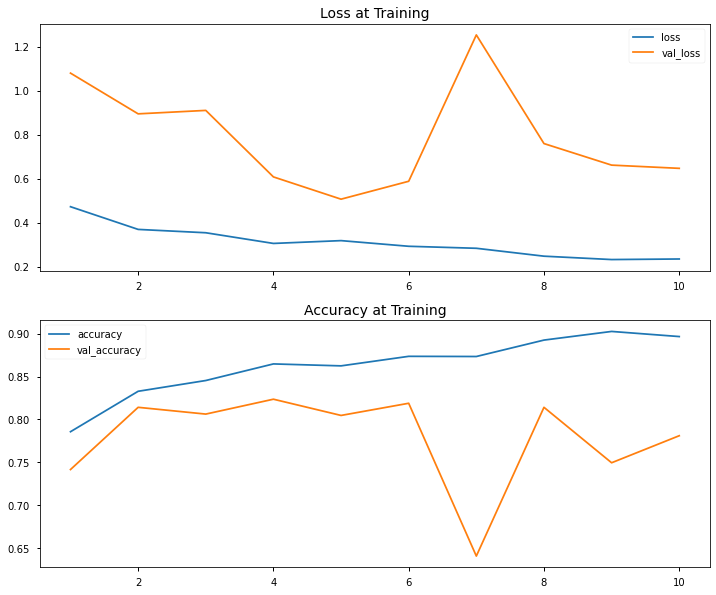

In [68]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize = (12, 10))
ax1.plot(range(1, EPOCHS + 1), history.history['loss'], label = 'loss')
ax1.plot(range(1, EPOCHS + 1), history.history['val_loss'], label = 'val_loss')
ax1.set_title('Loss at Training', fontsize = 14)
ax1.legend()
ax2.plot(range(1, EPOCHS + 1), history.history['accuracy'], label = 'accuracy')
ax2.plot(range(1, EPOCHS + 1), history.history['val_accuracy'], label = 'val_accuracy')
ax2.set_title('Accuracy at Training', fontsize = 14)
ax2.legend()
fig.show()

### Load weights model
Load `weights` terbaik yang telah disimpan. 

#### Note :
* Untuk mendapatkan hasil yang sama dengan yang di submit pada website `BDC - Satria Data` bisa menggunakan `weights` yang telah kami simpan [disini](https://www.kaggle.com/pencarikebahagiaan/modelku). 
* Untuk melihat proses training menggunakan data dengan kriteria Up-Sampling lainnya untuk perbandingan silahkan kunjugi notebook pada responsitory kami [di sini](https://github.com/Hyuto/BDC-Satria-Data/tree/master/Notebooks)

In [69]:
# model.load_weights('EfficientNetB7_best_model.h5')
model.load_weights('../input/modelku/Image Model/200%_best_model.h5') # Jika menggunakan Model kami

### Memprediksi dan Mengevaluasi Data
Memprediksi data train dan data valid lalu dilakukan pengevaluasian untuk melihat kebaikan model.

In [70]:
# Valid 
val_pred = model.predict(np.concatenate([x for x, y in valid_dataset], axis=0))
val_pred_classes = np.array(val_pred.flatten() >= .5, dtype = 'int')

Mengevaluasi model dengan `Accuracy Score` dan `F1 Score`.

In [71]:
print(f'Accuracy Valid Data : {accuracy_score(VAL_y, val_pred_classes)}')
print(f'F1 Score Valid Data : {f1_score(VAL_y, val_pred_classes)}')

Accuracy Valid Data : 0.8299212598425196
F1 Score Valid Data : 0.9040852575488455


Confussion Matrix

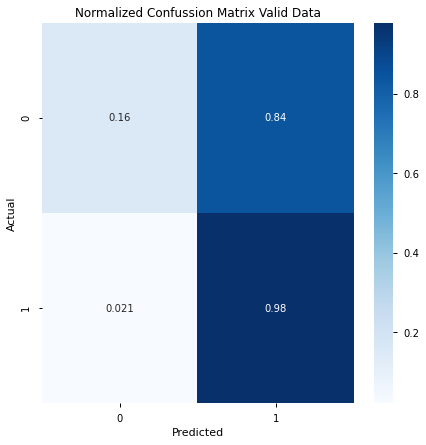

In [72]:
plt.figure(figsize = (7, 7))
sns.heatmap(confusion_matrix(VAL_y, val_pred_classes, normalize = 'true'), 
            annot=True, cmap=plt.cm.Blues)
plt.title('Normalized Confussion Matrix Valid Data')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

### Memprediksi Data Test
Menggunakan model untuk memprediksi `test dataset`.

In [73]:
EfficientNet_pred = model.predict(test_dataset)

Clear session & free up memory.

In [74]:
K.clear_session()
tf.tpu.experimental.initialize_tpu_system(tpu)

## Pemodelan Data Teks (BERT)<a class="anchor" id="chapter3_2"></a>
BERT(Bidirectional Encoder Representations from Transformers) adalah pretrained model karya Jacob Devlin, Ming-Wei Chang, Kenton Lee dan Kristina Toutanova. Model ini berupa transformator dua arah yang telah dilatih sebelumnya.

Published Paper : [BERT](https://arxiv.org/abs/1810.04805)

Bert yang digunakan pada notebook ini adalah `bert-base-indonesian` buatan `Cahya Wirawan` yang berupa pre-trained BERT-base model pada 522MB data wikipedia indonesia dengan vocabulary sebesar 32.000. Keterangan lebih lanjut bisa dibaca [di sini](https://huggingface.co/cahya/bert-base-indonesian-522M)

Load Transformers terlebih dahulu

In [75]:
from transformers import *

wandb: WARNING W&B installed but not logged in.  Run `wandb login` or set the WANDB_API_KEY env variable.


### Load Bert Tokenizer
Load Bert Tokenizer dari library `transformers`

In [76]:
model_name='cahya/bert-base-indonesian-522M'
tokenizer = BertTokenizer.from_pretrained(model_name)

### Encode Teks
Data teks akan di encode menjadi 3 tipe untuk input kedalam model.
* input ids adalah ID / nomor yang merepresentasikan kata
* attention mask adalah keterangan dari ID yang harus diperhatikan ditandakan oleh nomor 1.
* token type id adalah ID yang berhubungan dengan multiple sequance.

In [77]:
index = random.randint(0, len(train_text))
encode = tokenizer.encode_plus(train_text[index], return_attention_mask = True,
                               return_token_type_ids=True)
print('Actual : ')
print(train_text[index])
print(''.rjust(80, '-'))
print('Token IDS : ')
print(encode["input_ids"])
print(''.rjust(80, '-'))
print('Attention Mask : ')
print(encode['attention_mask'])
print(''.rjust(80, '-'))
print('Token Type IDS : ')
print(encode['token_type_ids'])

Actual : 
jokowi ahok bagikan amplop berisi uang beras warga cilincing jokowi ikutan sembako amplop ahok cilincing
--------------------------------------------------------------------------------
Token IDS : 
[3, 15071, 29708, 28939, 2688, 9155, 3709, 3714, 2111, 3167, 23190, 1010, 5398, 15071, 3821, 1487, 4461, 9745, 2688, 9155, 29708, 23190, 1010, 5398, 1]
--------------------------------------------------------------------------------
Attention Mask : 
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
--------------------------------------------------------------------------------
Token Type IDS : 
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


### Mengecek Sequence Terpanjang
Karena panjang dari data teks tidak sama. Maka perlu di lakukan padding untuk menyamakan panjang dari sequance. 

Contoh:
```
jokowi ahok bagikan => Encode IDS => [3, 15071, 29708] => Padding to 5 => [3, 15071, 29708, 0, 0]
```
Untuk melakukan padding perlu dicari sequence terpanjang pada data sebagai acuannya.

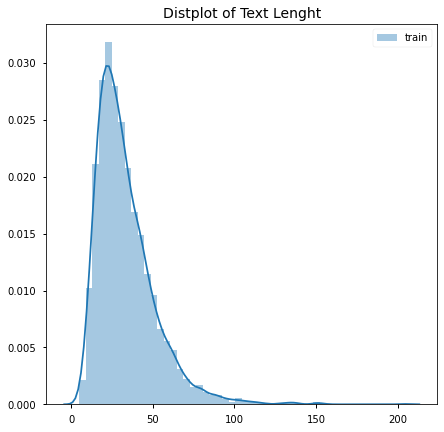

In [78]:
plt.figure(figsize=(7,7))
sns.distplot([len(tokenizer.encode(x)) for x in train_text], label = 'train')
plt.title('Distplot of Text Lenght', fontsize=14)
plt.legend()
plt.show()

Dari grafik diatas didapatkan kesimpulan bahwa panjang sequence data tersebar pada rentang 0 - 220 yang memusat pada rentang 0 - 100. Maka dari itu akan digunakan `250` sebagai acuan maximum dari panjang sequencenya

In [79]:
max_len = 250

In [80]:
def regular_encode(texts, tokenizer = tokenizer, maxlen=max_len):
    """
    Encoding data teks
    """
    enc_di = tokenizer.batch_encode_plus(
        texts, 
        return_attention_masks=True, 
        return_token_type_ids=True,
        pad_to_max_length=True,
        max_length=maxlen
    )
    
    return {x : np.asarray(enc_di[x]) for x in enc_di}

### Membuat Model
Membuat model yang digunakan untuk memprediksi data teks, berikut adalah arsitekturnya
<img src="https://raw.githubusercontent.com/Hyuto/BDC-Satria-Data/master/Sample%20Images/model_2.png" alt="BertModel" width="700" height="800" style="display: block; margin-left: auto; margin-right: auto;"/>

In [81]:
def build_model(transformer, loss='binary_crossentropy', max_len=max_len):
    input_ids = tf.keras.Input(shape=(max_len,), dtype=tf.int32, name="input_ids")
    attention_mask = tf.keras.Input(shape=(max_len,), dtype=tf.int32, name='attention_mask')
    token_type_ids = tf.keras.Input(shape=(max_len,), dtype=tf.int32, name='token_type_ids')
    
    sequence_output, pooled_output = transformer([input_ids, attention_mask, token_type_ids])
    cls_token = sequence_output[:, 0, :]
    x = L.Dropout(0.3)(cls_token)
    out = L.Dense(1, activation='sigmoid')(x)
    
    model = tf.keras.Model(inputs=[input_ids, attention_mask, token_type_ids], outputs=out)
    model.compile(Adam(lr=3e-5), loss=loss, metrics=['accuracy'])
    
    return model

### Cross Validation

Metode yang digunakan untuk CV adalah `StratifiedKflod`. Metode ini digunakan untuk mengatasi kelas pada data yang imbalance. `StratifiedKfold` ini tidak jauh berbeda dengan `Kfold` hanya pada saat pembagian menjadi data train dan data valid, proporsi masing masing kelas tetap sama pada kedua data tersebut.
<img src="https://raw.githubusercontent.com/Hyuto/BDC-Satria-Data/master/Sample%20Images/StratifiedKfold.png" alt="StratifiedKfold" width="600" height="800" style="display: block; margin-left: auto; margin-right: auto;"/>

`n_split` yang digunakan sebesar 10. Dataset Folding kami bisa di daoat dengan menggunakan:
```
cv = StratifiedKFold(n_splits=10)
for fold, (train_ind, val_ind) in enumerate(cv.split(train_text, train.label.values)):
    x_train, y_train = train_text[train_ind], train.label.values[train_ind]
    x_val, y_val = train_text[val_ind], train.label.values[val_ind]
```

load `folding.csv` dari responsitory kami.

In [82]:
# Load Folding Dataset from responsitory
folding = pd.read_csv('https://raw.githubusercontent.com/Hyuto/BDC-Satria-Data/master/Folding.csv')
folding.head()

ID  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Fold 6  Fold 7  Fold 8  \
0   71       1       1       1       1       1       1       1       1   
1  461       1       0       1       1       1       1       1       1   
2  495       1       1       1       1       1       1       1       1   
3  550       1       1       1       1       0       1       1       1   
4  681       1       1       1       0       1       1       1       1   

   Fold 9  Fold 10  
0       1        0  
1       1        1  
2       1        0  
3       1        1  
4       1        1

### Train & Evaluate Model
Melakukan `training` pada train data. Train dilakukan pada `fold 3` & `fold 6` karena kedua fold tersebut memberikan nilai akurasi yang cukup baik dari model pada `fold` lainnya. Training memiliki konfihurasi sebagai berikut:
```
epochs = 15
steps_per_epoch = len(x_train)//BATCH_SIZE:128 (jika menggunakann TPU)
```
Training dilakukan dengan memperhatikan nilai `val_accuracy` pada setiap epochnya. Epoch dengan score `val_accuracy` tertinggi akan di save `weight` - nya untuk diload saat melakukan evaluasi dan pemrediksian terhadap data test.

In [83]:
# Init
scores_valid, scores_test, CMS = [], [], []
HISTORY = []

# Test Dataset
test_dataset = (tf.data.Dataset
    .from_tensor_slices((regular_encode(test_text)))
    .batch(BATCH_SIZE)
)

for i in range(1, 11):
    if i in [3, 6]: # Ambil Fold 3 dan 6
        K.clear_session()
        tf.tpu.experimental.initialize_tpu_system(tpu)
        
        fold = f'Fold {i}'
        print(f'[INFO] {fold}')

        # Split Dataset per Fold
        x_train = train_text[folding[fold].values == 1]
        y_train = train.label.values[folding[fold].values == 1]
        x_val = train_text[folding[fold].values == 0]
        y_val = train.label.values[folding[fold].values == 0]

        # Encoding & to TF Dataset
        train_dataset = (tf.data.Dataset
            .from_tensor_slices((regular_encode(x_train), y_train))
            .batch(BATCH_SIZE)
            .cache()
            .repeat()
            .shuffle(1024)
            .prefetch(AUTO)
        )
        valid_dataset = (tf.data.Dataset
            .from_tensor_slices((regular_encode(x_val), y_val))
            .batch(BATCH_SIZE)
            .cache()
            .prefetch(AUTO)
        )
        
        # Training
        with strategy.scope(): # Build & Scoope Model
            BERT = TFBertModel.from_pretrained(model_name)
            model = build_model(BERT)
            
        checkpoint = ModelCheckpoint(f'Fold_{i}_best_model.h5', monitor='val_accuracy', 
                                     save_best_only=True, save_weights_only=True, 
                                     mode='max')
        
        history = model.fit(train_dataset, epochs = 15, 
                            steps_per_epoch = len(x_train)//BATCH_SIZE,
                            validation_data = valid_dataset,
                            callbacks = [checkpoint])

        # Load Weights
        # model.load_weights(f'Fold_{i}_best_model.h5') # Trained Best Weights
        model.load_weights(f'../input/modelku/{fold}_best_model.h5') # Catatan Cakrawala Weights

        # Predict
        pred_val  = model.predict(valid_dataset)  # Valid
        pred_test = model.predict(test_dataset)   # Test

        scores_valid.append(pred_val.flatten())
        scores_test.append(pred_test.flatten())
        CMS.append(confusion_matrix(y_val, np.array(pred_val.flatten() >= .5, dtype='int'),
                                    normalize = 'true'))
        HISTORY.append(history.history)

print(f'[INFO] Done')

[INFO] Fold 3



Epoch 1/15
29/29 [==============================] - 51s 2s/step - loss: 0.6275 - accuracy: 0.7686 - val_loss: 0.4344 - val_accuracy: 0.8298
Epoch 2/15
29/29 [==============================] - 8s 277ms/step - loss: 0.4023 - accuracy: 0.8413 - val_loss: 0.4263 - val_accuracy: 0.8487
Epoch 3/15
29/29 [==============================] - 6s 199ms/step - loss: 0.3162 - accuracy: 0.8770 - val_loss: 0.4730 - val_accuracy: 0.8440
Epoch 4/15
29/29 [==============================] - 6s 200ms/step - loss: 0.2479 - accuracy: 0.9083 - val_loss: 0.5341 - val_accuracy: 0.7967
Epoch 5/15
29/29 [==============================] - 6s 202ms/step - loss: 0.1471 - accuracy: 0.9448 - val_loss: 0.5429 - val_accuracy: 0.8322
Epoch 6/15
29/29 [==============================] - 6s 201ms/step - loss: 0.0654 - accuracy: 0.9777 - val_loss: 0.7967 - val_accuracy: 0.8227
Epoch 7/15
29/29 [==============================] - 6s 203ms/step - loss: 0.0401 - accuracy: 0.9857 - val_loss: 0.8853 - val_accuracy: 0.8132
Epoch 8

Meninjau `train history` pada model setiap `fold` - nya

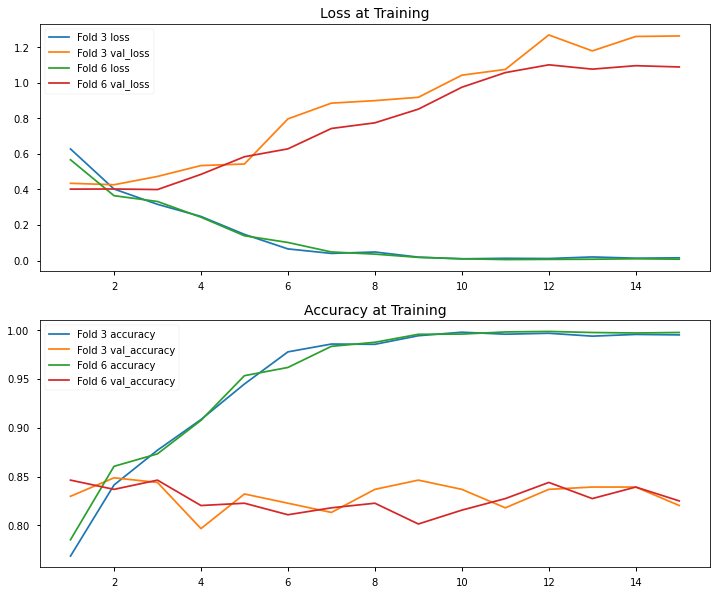

In [84]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize = (12, 10))
for i, fold in enumerate([3, 6]):
    ax1.plot(range(1, 16), HISTORY[i]['loss'], label = f'Fold {fold} loss')
    ax1.plot(range(1, 16), HISTORY[i]['val_loss'], label = f'Fold {fold} val_loss')
    ax2.plot(range(1, 16), HISTORY[i]['accuracy'], label = f'Fold {fold} accuracy')
    ax2.plot(range(1, 16), HISTORY[i]['val_accuracy'], label = f'Fold {fold} val_accuracy')
ax1.set_title('Loss at Training', fontsize = 14)
ax2.set_title('Accuracy at Training', fontsize = 14)
ax1.legend()
ax2.legend()
fig.show()

Confussion Matrix prediksian model terhadap data valid per - `foldnya`

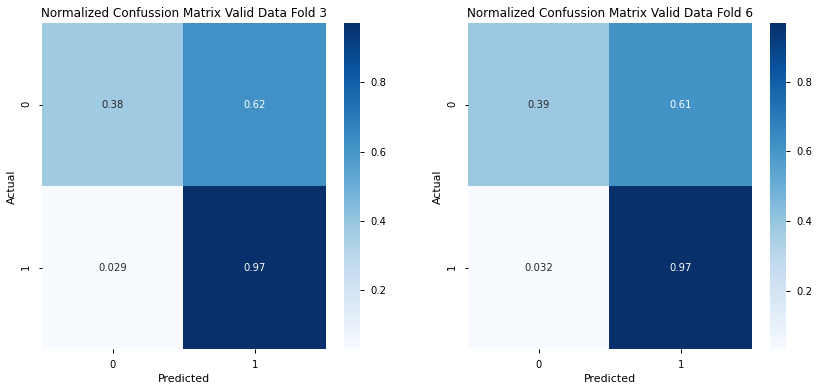

In [85]:
# Plotting Confussion Matrix
fig, ax = plt.subplots(1, 2, figsize = (14, 6))
i = 0
for j in range(10):
    if j in [2, 5]:
        sns.heatmap(CMS[i], annot=True, cmap = plt.cm.Blues, ax = ax[i])
        ax[i].set_title(f'Normalized Confussion Matrix Valid Data Fold {j + 1}')
        ax[i].set_xlabel('Predicted')
        ax[i].set_ylabel('Actual')
        i += 1
fig.show()

# Ensemble<a class="anchor" id="chapter4"></a>
> Ensemble is methods use multiple learning algorithms to obtain better predictive performance than could be obtained from any of the constituent learning algorithms alone.

Untuk mendapatkan hasil yang lebih baik kami melakukan `ensembling` pada hasil prediksi model kami. Hasil model yang di `ensembling` adalah hasil peramalan data test pada model `EfficientNetB7` dan model `Bert` pada fold `3` dan `6`. Metode ensemble yang digunakan adalah dengan mengambil rata - rata probabilitas dari hasil prediksian ketiga model tersebut.<a class="anchor" id="chapter4_1"></a>

In [86]:
ensemble = (EfficientNet_pred.flatten() + scores_test[0] + scores_test[1]) / 3

## Mencari Threshold<a class="anchor" id="chapter4_2"></a>
> The decision for converting a predicted probability or scoring into a class label is governed by a parameter referred to as the “threshold” The default value for the threshold is 0.5 for normalized predicted probabilities or scores in the range between 0 or 1.

Kami mendapatkan beberapa indikasi bahwa untuk mendapatkan hasil yang lebih baik perlu dilakukan penggeseran terhadap tresholdnya:
1. Kelas pada label yang tidak berimbang<br>
Kelas `0` pada label memiliki frekuensi yang sangat kecil, berbeda jauh jika dibandingkan dengan pada kelas `1`. Kami menduga hal ini berpengaruh terhadap berat masing - masing kelas pada saat dilakukan pemodelan `tidak sama`.
1. Nilai loss dan akurasi yang berbanding lurus pada saat training<br>
Pada saat training kami mendapatkan ketika `val_loss` (validation loss) menaik `val_accuracy` juga tetap menaik untuk beberapa saat. Hal ini cukup aneh karena seharusnya ketika nilai loss menaik maka nilai akurasi menurun. Hal ini membawa kami pada kesimpulan bahwa `threshold`-nya perlu untuk dirubah. 

Mengecek distribusi peluang `ensemble`

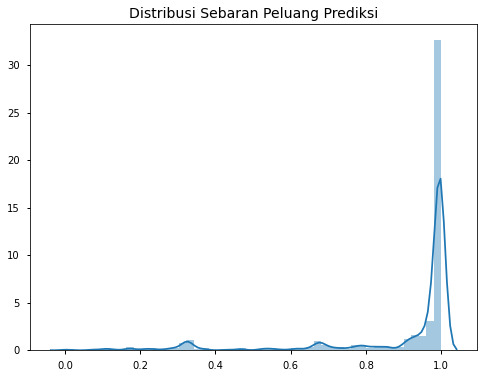

In [87]:
plt.figure(figsize = (8,6))
sns.distplot(ensemble)
plt.title('Distribusi Sebaran Peluang Prediksi', fontsize = 14)
plt.show()

Dapat dilihat dari plot diatas bahwa sebaran peluang mulai memusat pada selang `0.65` - `1`.

Maka dari itu kami putuskan untuk mengambil `0.65` sebagai `threshold`-nya.

## Membuat Submission
Membuat Submission File.

In [88]:
test['prediksi'] = np.array(ensemble > .65, dtype = 'int')
submission_temp = pd.read_csv('../input/data-bdc/Submission Template.csv')[['ID']]
hasil = submission_temp.merge(test[['ID', 'prediksi']], on = 'ID')
hasil.head()

ID  prediksi
0     56         1
1   1129         1
2   8468         1
3   9527         1
4  11152         1

In [89]:
hasil.to_csv('Catatan Cakrawala BDC - Ensemble.csv', index = False)

# Kesimpulan & Saran<a class="anchor" id="chapter5"></a>
## Kesimpulan
1. Data memiliki frekuensi kelas yang `tidak berimbang` sehingga perlu di perhatikan saat pembuatan model
1. Dengan menggukan model yang kami buat didapatkan hasil yang cukup baik dengan f1 score 94 % namun memerlukan komputasi yang cukup berat dan biaya yang mahal untuk ukuran data yang tidak terlalu besar.

## Saran
1. Jika memungkinkan diperlukan `penambahan data` pada label bukan hoax agar frekuensi setiap kelas pada data tidak berbanding cukup jauh
1. Menggunakan model `multimodal` karena hasil pada ensembel model gambar dan model teks menunjukkan hasil yang lebih baik.

© Catatan Cakrawala 2020